<a href="https://colab.research.google.com/github/gianlucamalato/machinelearning/blob/master/Covid_19_Correlation_with_pollution_in_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

from scipy.stats import fisher_exact,spearmanr

import matplotlib.pyplot as plt
%matplotlib inline

# Data preparation

In [0]:
url_pollution = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSBF0Jz0IZezYodgtLRrQouH9KDuVJ5D3A12KAG263jDJT9xB3gKK7mlei7R316DCsRv1_AY9LVEOyk/pub?gid=1738056038&single=true&output=csv"

In [0]:
url_infections = "https://github.com/pcm-dpc/COVID-19/raw/master/dati-province/dpc-covid19-ita-province.csv"

In [0]:
pollution = pd.read_csv(url_pollution)

In [157]:
pollution.loc[:,['City/Town','Annual mean, ug/m3']].head()

,City/Town,"Annual mean, ug/m3"
0,Tirana,32
1,Vlore,23
2,Vrith,20
3,Escaldes-Engordany,19
4,Abu Dhabi,150


In [0]:
infections = pd.read_csv(url_infections)

In [159]:
infections.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0
1,2020-02-24 18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0
2,2020-02-24 18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0
3,2020-02-24 18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0
4,2020-02-24 18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,NaN,0.000000,0.000000,0


Converting dates into numbers

In [0]:
FMT = '%Y-%m-%d %H:%M:%S'
date = infections['data']
infections['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )

# Calculating daily infection rate (average of daily change of total infected people)

In [0]:
infection_rate = pd.DataFrame({'city':[],'infection_rate':[]})

for city in infections['denominazione_provincia'].unique():
  # Only get days when there have been infected people
  subset = infections[(infections['denominazione_provincia'] == city) & (infections['totale_casi'] > 0)].sort_values('data')
  
  # Mean value of the differences between consecutive points
  city_infection_rate =  np.mean(subset['totale_casi'].diff(1)) 
  
  infection_rate = infection_rate.append(pd.DataFrame({'city':[city],'infection_rate':[city_infection_rate]}))

In [162]:
infection_rate.sort_values('infection_rate',ascending=False).head(10)

,city,infection_rate
0,Bergamo,214.000000
0,Brescia,202.000000
0,Milano,158.166667
0,Cremona,97.458333
0,Piacenza,64.875000
0,Torino,64.708333
0,Lodi,61.333333
0,Pesaro e Urbino,47.739130
0,Pavia,44.916667
0,Padova,41.500000


# Joining the datasets by city name

In [0]:
pollution_infections = pd.merge(pollution,infection_rate,left_on=['City/Town'],right_on=['city'])[['city','Annual mean, ug/m3','infection_rate']]

In [164]:
pollution_infections.head()

,city,"Annual mean, ug/m3",infection_rate
0,Alessandria,32,34.941176
1,Ancona,26,26.947368
2,Aosta,18,17.466667
3,Arezzo,22,6.833333
4,Ascoli Piceno,19,4.666667


In [165]:
pollution_infections.shape

(87, 3)

# Spearman correlation coefficient 

In [166]:
x = pollution_infections.iloc[:,1]
y = pollution_infections.iloc[:,2]

print(spearmanr(x,y))

SpearmanrResult(correlation=0.4196104591904644, pvalue=5.2179356018526234e-05)


# Correlation plot

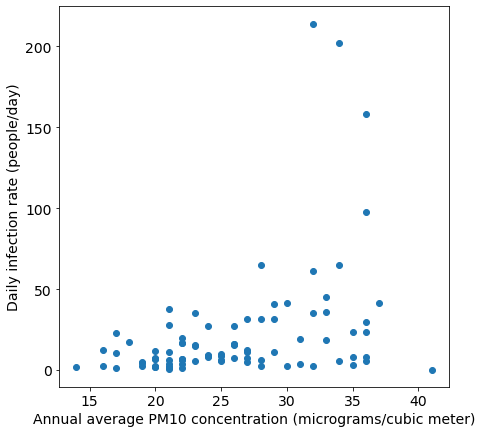

In [167]:
plt.rcParams['figure.figsize'] = [7, 7]

plt.rc('font', size=14) 

plt.scatter(x,y)
plt.xlabel("Annual average PM10 concentration (micrograms/cubic meter)")
plt.ylabel("Daily infection rate (people/day)")
plt.show()

# Average national infection rate

In [0]:
avg_national_infection_rate = np.mean(pollution_infections['infection_rate'])

In [169]:
avg_national_infection_rate

22.214203597119393

# Average national pollution index

In [0]:
avg_national_pollution = np.mean(pollution_infections['Annual mean, ug/m3'])

In [171]:
avg_national_pollution

25.95402298850575

In [0]:
pollution_infections['flag_high_infection_rate'] = [int(x) for x in pollution_infections['infection_rate'] > avg_national_infection_rate]
pollution_infections['flag_high_pollution'] = [int(x) for x in pollution_infections['Annual mean, ug/m3'] > avg_national_pollution]


# Correlation between pollution and infection

## Crosstab

In [0]:
ctab_poll_inf = pd.crosstab(pollution_infections.flag_high_pollution,pollution_infections.flag_high_infection_rate)

In [174]:
ctab_poll_inf

flag_high_infection_rate,0,1
flag_high_pollution,,
0,40,5
1,22,20


## Fisher's test p-value

In [175]:
fisher_exact(ctab_poll_inf)[1]

0.00027536798628374553